# PEFT Fine Tuning TinyLlama LLM Chat Instruct Model
* Notebook by Adam Lang
* Date: 1/8/2024

# Overview
* In this notebook we will go over how to fine tune a TinyLlama LLM for chat/instruct tasks on a multi-turn conversation dataset.

# Normalized Quantization — QLoRA

* Recall this uses normalized quantization to quantize low-rank matrices.
* This ensures that quantized weights are normalized on the SAME scale as original weights preserving a models performance during fine-tuning tasks.

# Dataset
* The dataset we will use is the **Ultrachat_200k**.
* Task: fine tune on multi-turn conversational chat messages.
* Hugging Face dataset card: https://huggingface.co/datasets/HuggingFaceH4/ultrachat_200k


# Fine Tuning Config
* We will use `Bitsandbytes` in 4-bit since this is a larger model.

# Model
* TinyLlama
* This model has 1.1B parameters and 3 Trillion tokens.
* We will do the following:

1. Use the Tokenizer template from the already fine-tuned TinyLlama Chat model.
  * model card: https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0

2. Fine tune the TinyLlama base model for our chat task.
  * This may seem confusing but, the reasoning is that if we wanted a chat trained model already then we would just use the pre-trained chat model, but that is not what we are doing here with our dataset.
  * model card: https://huggingface.co/TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T

# Install Dependencies

In [ ]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Import Modules
* See full documentation: https://huggingface.co/docs/trl/en/sft_trainer

In [ ]:
## Standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

## ML imports
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, ## text generation head
    BitsAndBytesConfig, ## we need 4-bit config
    TrainingArguments, ##fine tuning
    Trainer, ## fine tuning
    DataCollatorForLanguageModeling, ## fine-tuning
    pipeline, ## for testing basemodel and inference
)
from datasets import load_dataset, Dataset, DatasetDict ## HF dataset, dataloaders
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model, ## LoRA config for fine-tuning
    AutoPeftModelForCausalLM ## causal inference
)

from trl import SFTTrainer, SFTConfig ## reinforcement learning from supervised fine-tuning
from accelerate import Accelerator



# Setup Device agnostic code
* If cuda is available we can use it.

In [ ]:
## device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device we are using: {device}")

Device we are using: cuda


# Load Dataset
* We will load dataset from Hugging Face.
* The dataset is divided up into 2 tasks:

1. Supervised fine-tuning (sft).
2. Generation ranking (gen) via techniques like rejection sampling or PPO.

* Since we are focusing on task chats, we will split the dataset when loading.


In [ ]:
## load dataset from HF
dataset = load_dataset("HuggingFaceH4/ultrachat_200k",
                       trust_remote_code=True,
                       split="train_sft")

dataset

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

(…)-00000-of-00003-a3ecf92756993583.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-0a1804bcb6ae68c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00002-of-00003-ee46ed25cfae92c6.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00000-of-00001-f7dfac4afe5b93f4.parquet:   0%|          | 0.00/81.2M [00:00<?, ?B/s]

(…)-00000-of-00003-a6c9fb894be3e50b.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

(…)-00001-of-00003-d6a0402e417f35ca.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00002-of-00003-c0db75b92a2f48fd.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

(…)-00000-of-00001-3d4cd8309148a71f.parquet:   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'prompt_id', 'messages'],
    num_rows: 207865
})

In [ ]:
## lets load only 10,000 rows rather than the entire dataset which is ~207,000 rows
dataset = dataset.shuffle(seed=42).select(range(10_000))

In [ ]:
## lets see output
dataset

Dataset({
    features: ['prompt', 'prompt_id', 'messages'],
    num_rows: 10000
})

Summary
* Now we have cut the dataset down to 10,000 rows which is perfect for what we are doing.

In [ ]:
## view an index
dataset[1]

{'prompt': 'Write an informative and persuasive article of 1000 words or more that discusses the environmental and economic benefits of using renewable energy sources, such as solar, wind and hydropower, for powering mining operations. Your article should highlight various case studies, statistics and research findings that demonstrate the feasibility, efficiency and cost-effectiveness of renewable energy solutions in the mining industry. Also, provide insight into the potential challenges, barriers and solutions for implementing renewable energy projects in mining sites worldwide. Use credible sources, technical terms and examples to strengthen your arguments and engage your readers. Finally, offer practical recommendations, policy suggestions or call to actions that inspire readers to support and promote the transition towards a cleaner and more sustainable mining industry.',
 'prompt_id': 'd89a653d6d671c30ef07c318e46ef44df29f25079b2dd5d21ade1af4db7efe0a',
 'messages': [{'content': '

# Chat Model Templates
* There are 2 methods to prepare the data for fine-tuning on chat tasks.

1. Manual method
  * This involves manually writing a function to use the structured chat template provided by TinyLlama as seen in the hugging face model card and github repo:

```
# <|system|>
# You are a friendly chatbot who always responds in the style of a pirate.</s>
# <|user|>
# How many helicopters can a human eat in one sitting?</s>
# <|assistant|>
# ...
```

2. Model Tokenizer method
  * This method uses the chat template direct from the model's tokenizer.
  * That format looks like this:

```
# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
```

Summary
* We will need to use the first method above to align with the structure of our dataset.

## Chat Template Preparation
* We will load the tokenizer template direct from the TinyLlama model, then work with it to format our data.

In [ ]:
## load tokenizer
template_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

## lets see template_tokenizer
template_tokenizer

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

LlamaTokenizerFast(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
## format chat template with tokenizer
def format_prompt(example):
  """
  Function formats prompt using TinyLlama format:
  <|user|> and <|assistant|>
  """
  chat = example["messages"]
  ## tokenize set to `False` to not apply masking, labels, ids --> applies chat format instead
  prompt = template_tokenizer.apply_chat_template(chat, tokenize=False)

  return {'text': prompt}

## test function
print(format_prompt(dataset[0])['text'])

<|user|>
How does the location of the Sydney Conservatorium of Music impact the academic and professional opportunities available to music students, and how does the conservatorium support student engagement with the music industry in Australia?</s>
<|assistant|>
The location of the Sydney Conservatorium of Music, which is situated in the heart of Sydney's cultural precinct, impacts both the academic and professional opportunities available to music students. The conservatorium is located near several major performing arts venues and organizations, including the Sydney Opera House, the Australian Broadcasting Corporation, and the Sydney Symphony Orchestra, providing students with easy access to performances, rehearsals, and networking opportunities.

One of the primary ways the conservatorium supports student engagement with the music industry in Australia is through its strong industry connections. The conservatorium has established partnerships with numerous professional music organi

Summary
* Now we have the proper format we need which is:
```
<|user|>
<|assistant|>
```


In [ ]:
## apply to entire dataset
dataset = dataset.map(format_prompt)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
## view dataset now
dataset[1]

{'prompt': 'Write an informative and persuasive article of 1000 words or more that discusses the environmental and economic benefits of using renewable energy sources, such as solar, wind and hydropower, for powering mining operations. Your article should highlight various case studies, statistics and research findings that demonstrate the feasibility, efficiency and cost-effectiveness of renewable energy solutions in the mining industry. Also, provide insight into the potential challenges, barriers and solutions for implementing renewable energy projects in mining sites worldwide. Use credible sources, technical terms and examples to strengthen your arguments and engage your readers. Finally, offer practical recommendations, policy suggestions or call to actions that inspire readers to support and promote the transition towards a cleaner and more sustainable mining industry.',
 'prompt_id': 'd89a653d6d671c30ef07c318e46ef44df29f25079b2dd5d21ade1af4db7efe0a',
 'messages': [{'content': '

# Testing Base TinyLlama Model "Out of the Box"
* This is an important experimental step with any LLM to use as a benchmark for fine-tuning tasks.
* We aim to see how the model performs on the task(s) we are fine-tuning for without actually fine-tuning.
* After we fine-tune we can then compare the generative output improvements from our fine-tuning task.

In [ ]:
# from transformers import pipeline --- if not done already above

## base model checkpoint
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"


## create inference pipeline
pipe = pipeline(task='text-generation', model=model_name, device=device)


## prompt format
# <|user|>, <|assistant|>
prompt = """
<|user|> Explain in 3 bullet points what Machine Learning is.</s>
<|assistant|>
"""

## set output
output = pipe(prompt)
output

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda


[{'generated_text': '\n<|user|> Explain in 3 bullet points what Machine Learning is.</s>\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assistant|>\n\n<|assista

Summary
* As we can see, the model has produced erratic output from the simple chat prompt template we gave it, hence why we need to fine-tune the base model.
* Let's first try one more test though and see how the model does without a chat template.


In [ ]:
## lets test the base model without the chat template
prompt = """ Explain in 3 bullet points what Machine Learning is.
"""

## set output
output = pipe(prompt)
output

[{'generated_text': ' Explain in 3 bullet points what Machine Learning is.\n\n* 1. Explain in 3 bullet points what the difference between supervised and unsupervised learning is.\n\n* 2. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 3. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 4. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 5. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 6. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 7. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 8. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 9. Explain in 3 bullet points what the difference between classification and regression is.\n\n* 10. Explain in 3 bullet points what the 

Summary
* Again it is clear the output is erratic and not well controlled at all even without a chat template, thus we will now finetune the model.

# Model Config for Training
* Here we need to build the model config for training the base model on the task of "chat instruction".
* Quick note about the config:
  * We will set the `bnb_4bit_quant_type` to "nf4" as this is `NormalFloat 4-bit`.
  * Pre-trained neural network weights are usually normally distributed and centered around zero.
       * So, here is a very high probability of values occurring closer to zero rather than around -1 or plus 1.
       * However, standard quantization to int4 is not aware of this fact.
       * Thus it goes by the assumption that each of the 16 bins has an equal probability of getting the values.
       * NF4 considers the normal distribution of neural network weights.
         * This is what QLoRA does and it names it `k-bit NormalFloat`.
         * **In NormalFloat, the bins are weighted by the normal distribution and hence the spacing between two quantization values are far apart near the extremes of -1 or 1 but are closer together as we get closer to 0. Thus we need to account for the long tails with FP or floating point quantization.** [source](https://www.ai-bites.net/qlora-train-your-llms-on-a-single-gpu/)

In [ ]:
## setup 4-bit quantization in Q-LoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # quant setting
    bnb_4bit_quant_type="nf4", #4-bit NormalFloat (NF4) —> optimized for normally distributed weights
    bnb_4bit_compute_dtype='float16', ## converts 4-bit to float16
    bnb_4bit_use_double_quant=True, # reduces memory footprint

)

Setup Tokenizer
* For this we also have to add padding.
* As a general rule of thumb, when doing Causal Language Modeling (e.g. generative outputs), you want to use padding on the left as we "look left and predict right".
* Otherwise with right sided padding it is masked in the middle of the sentence and will not produce the desired output.

In [ ]:
## load tokenizer from base model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
## add padding --> generative outputs
tokenizer.pad_token = "<PAD>"
tokenizer.padding_size= "left"

Load Model

In [ ]:
## loading model
model = AutoModelForCausalLM.from_pretrained(
    model_name, #base model
    device_map="auto",
    quantization_config=bnb_config, ## see above
)

Set additional config params
* Setting `config.pretraining_tp` to a value different than 1 will activate the more accurate but slower computation of the linear layers, which should better match the original logits.
* tp is tensor parallelism which distributes training across GPUs.
* Read more here: https://lightning.ai/lightning-ai/studios/tensor-parallelism-supercharging-large-model-training-with-pytorch-lightning?section=featured

In [ ]:
## continue setting model config
model.config.use_cache=False
model.config.pretraining_tp=1

In [ ]:
## check model config
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05

Summary

* Question: What is a neural network without its hidden states?

* Answer: Single-layer network

* Question: What is a single layer network?

* Answer: Linear model

Yes, a single neural network is simply:
``` `y=mx+b`
```
Which is the equation for linear regression. However, it is rewritten as:


`F(x) = wTx + b`



* Ok wait. But Linear Regression is a linear model. Yet the purpose of neural networks is to handle non-linear data and we know they are non-linear, so how can we say linear regrssion is a neural network?

  * Answer: Activation functions

* Ok its not that simple, but you get the point.


* This is why I think its important to understand the “guts” of the model you are working with. As an example, lets say you are using TinyLlama, it looks like this, We can see there  are:

1. 22 decoder layers
2. `out_features` is 32,000 which is based on dictionary size.
3. Optimizer --> `RMSNorm`
  * RMSNorm : Root Mean Square Layer Normalization.
  * **LLaMA normalizes the input of each transformer sub-layer, instead of normalizing the output.**
  * Inspiration of including pre-normalization is taken from GPT3.
  * RMSNorm is extension of Layer Normalization (LayerNorm).
  * Reason behind using RMSNorm is the computational overhead in LayerNorm. This makes improvements slow and expensive.
  * RMSNorm achieves comparable performance against LayerNorm but reduces the running time by `7%∼64%.`


4. Activation function --> `SiLU`
  * Sigmoid-weighted Linear Unit (SiLU)

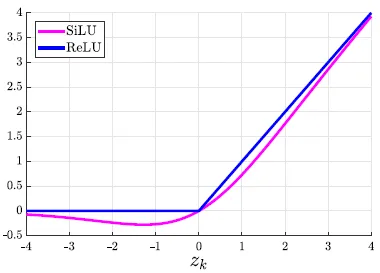

* Unlike the ReLU (and other commonly used activation units such as sigmoid and tanh units), SiLU is not monotonically increasing.
* Instead, it has a global minimum value of approximately `−0.28 for zk ≈ −1.28`. * SiLU has a self-stabilizing property.
  * The global minimum, where the derivative is zero, functions as a `soft floor` on the weights that serves as an implicit regularizer that inhibits the learning of weights of large magnitudes.

Sources
* https://sh-tsang.medium.com/review-silu-sigmoid-weighted-linear-unit-be4bc943624d
* https://medium.com/@asifurrahmanaust/lesson-3-neural-network-is-nothing-but-a-linear-regression-e05a328a0f23
* https://akgeni.medium.com/llama-concepts-explained-summary-a87f0bd61964
* https://2020machinelearning.medium.com/deep-dive-into-deep-learning-layers-rmsnorm-and-batch-normalization-b2423552be9f


# LoRA Config for PEFT Fine Tuning
* Now we need to prepare the LoRA layers for fine tuning.

In [ ]:
## lets see the model layers again
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05

## Target layers for fine-tuning
* Here we want to target these layers as seen above:
```
(0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
```
* And these:
```
(mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear4bit(in_features=5632, out_features=2048, bias=False)
```

In [ ]:
## imports if not done above
# from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


## setup peft_config
peft_config = LoraConfig(
    lora_alpha=32, #higher value is more matrix decomposition
    lora_dropout=0.1,
    r=64,
    bias='none',
    task_type='CAUSAL_LM', #CAUSAL_LM or MASK_LM --> causal for decoder
    target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','up_proj','down_proj'], ## layers for training
)

## prepare model
model = prepare_model_for_kbit_training(model)


## peft model config
model = get_peft_model(model, peft_config)

In [ ]:
## view model config now
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): l

### LoRA Explanation
* We can see that we successfully added the LoRA layers.
* Below we can see a layer of the lora:
```
(base_layer): Linear4bit(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=256, bias=False)
```

In [ ]:
## calculating this out:
w = 2048 * 256 #layer 1
a = 2048 * 64 # lora_A
b = 64 * 256 # lora_b

w, a, b, a+b, (a+b)/w

(524288, 131072, 16384, 147456, 0.28125)

Summary of the layer above:
* We can see that if we don't break down the w matrix for this layer, we would have to train 524,288 parameters which is a lot of compute power, and that is just 1 attention layer of many.
* However, since we are decomposing the matrix into `lora_a` which is 131,072 and `lora_b` which is `147,456` we are only training about 28% of this layer while still maintaining functionality and efficiency.

# Model Fine Tuning Task - Chat Model
* `lr_scheduler_type="cosine"`
  * This means that we are using **cosine annealing***.
  * originally introduced by Loshchilov et al. in SGDR: Stochastic Gradient Descent with Warm Restarts
 * *Cosine Annealing is a type of learning rate schedule that has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again. The resetting of the learning rate acts like a simulated restart of the learning process and the re-use of good weights as the starting point of the restart is referred to as a "warm restart" in contrast to a "cold restart" where a new set of small random numbers may be used as a starting point.*
 * [Source](https://paperswithcode.com/method/cosine-annealing#:~:text=Introduced%20by%20Loshchilov%20et%20al,before%20being%20increased%20rapidly%20again.)

 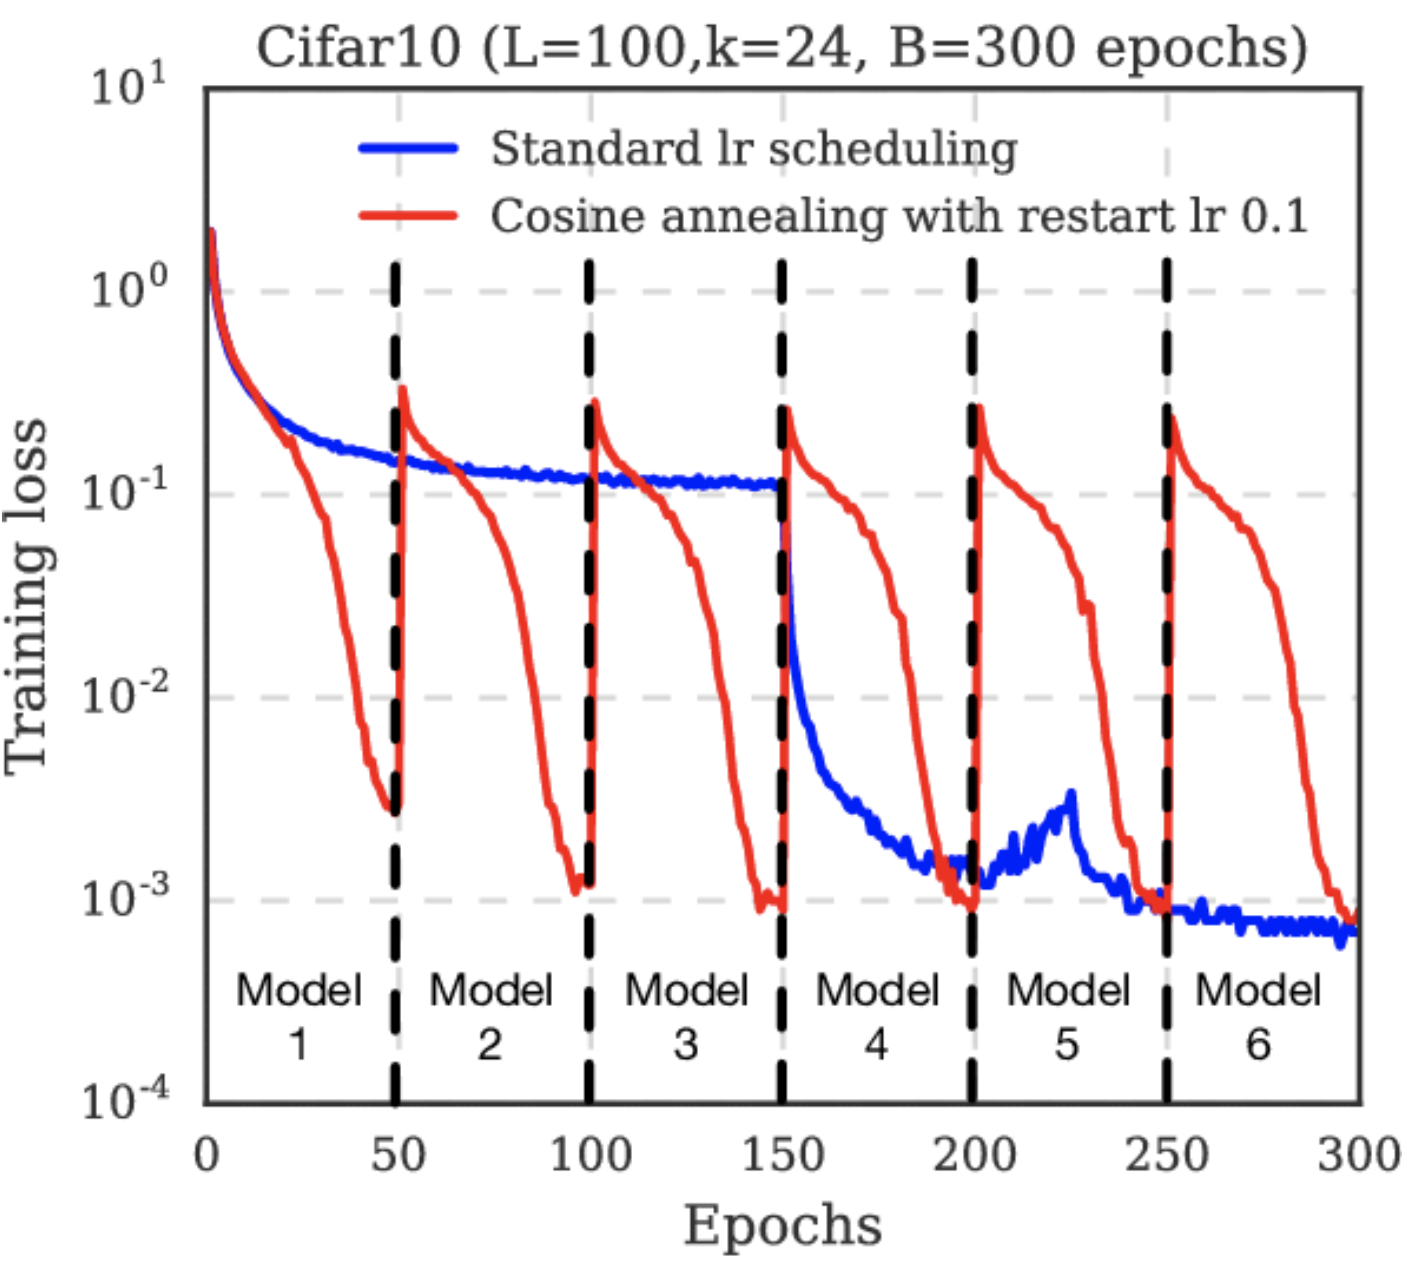

In [ ]:
type(dataset)

datasets.arrow_dataset.Dataset

### Supervised Fine Tuning Trainer - Dataset Format
* Even though we had applied the prompt format function above, we need to put this into the trainer instead of the tokenizer.
* The full docs are here: https://huggingface.co/docs/trl/en/sft_trainer
* This includes accounting for:
  * New tokens that are added in prompts.
  * Prompt formats
  * ...and other examples...
* So i am applying the prompt format function below to the trainer. as per the docs.

In [ ]:
## if have not imported above
# from transformers import TrainingArguments, Trainer
# from trl import SFTTrainer

output_dir = "train_dir"

## need to format prompts if not in correct format
## see docs: https://huggingface.co/docs/trl/en/sft_trainer
def format_prompt(example):
  """
  Function formats prompt using TinyLlama format:
  <|user|> and <|assistant|>
  """
  chat = example["messages"]
  ## tokenize set to `False` to not apply masking, labels, ids --> applies chat format instead
  prompt = template_tokenizer.apply_chat_template(chat, tokenize=False)

  return prompt



# train args
args = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit", ## handles spiked gradient accumulation
    learning_rate=2e-4,
    lr_scheduler_type="cosine", ## see above
    num_train_epochs=1,
    logging_steps=10,
    fp16=True,
    gradient_checkpointing=True, #save model weights

)

## init accelerator
accelerator = Accelerator()

## setup trainer
trainer = accelerator.prepare(SFTTrainer(
    model,
    train_dataset=dataset,
    args=args,
    formatting_func=format_prompt, ## apply prompt format function using tokenizer default
    peft_config=peft_config
))

## train model
trainer.train()

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,1.569100
20,1.463300
30,1.396200
40,1.341000
50,1.331900
60,1.266900
70,1.337600
80,1.263900
90,1.346100
100,1.382500


Step,Training Loss
10,1.569100
20,1.463300
30,1.396200
40,1.341000
50,1.331900
60,1.266900
70,1.337600
80,1.263900
90,1.346100
100,1.382500


TrainOutput(global_step=1250, training_loss=1.2485684898376466, metrics={'train_runtime': 8724.6047, 'train_samples_per_second': 1.146, 'train_steps_per_second': 0.143, 'total_flos': 6.557894623575245e+16, 'train_loss': 1.2485684898376466, 'epoch': 1.0})

# Save the model

In [ ]:
## saving the model
trainer.model.save_pretrained("TinyLlama-1.1B-qlora")

# Load Pre-Trained PEFT Model for Prediction
* We already saw how the base model performs without fine tuning.
* We can use the same testing prompt and evaluate its performance on the fine tuned model.

In [ ]:
## if you want to run inference starting here
from peft import AutoPeftModelForCausalLM

## load model
model = AutoPeftModelForCausalLM.from_pretrained(
    "TinyLlama-1.1B-qlora",
    device_map="auto",

)
# merge lora weights with base model
merged_model = model.merge_and_unload()

In [ ]:
## view merged_model
merged_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): 

# Inference on Fine-Tuned Model

In [ ]:
## import pipeline
from transformers import pipeline


## Test prompt #1
prompt = """<|user|>
Explain in 3 bullet points what Machine Learning is.</s>
<|assistant|>
"""

# ## Test prompt #2
# prompt = """
# Explain in 3 bullet points what Machine Learning is.
# """

## load tokenizer from base model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
## add padding --> generative outputs
tokenizer.pad_token = "<PAD>"
tokenizer.padding_size= "left"

## create pipeline
pipe = pipeline(task='text-generation',
                model=merged_model, ## lora weights merged with base model
                tokenizer=tokenizer) ## original tokenizer


## get output
output = pipe(prompt)
print(output[0]['generated_text'])

Device set to use cuda:0


<|user|> 
Explain in 3 bullet points what Machine Learning is.</s>
<|assistant|>
Machine Learning is a field of computer science that involves the use of algorithms and data to learn from data. It is a process of developing algorithms that can learn from data and make predictions based on the data. Machine Learning is used in various fields such as healthcare, finance, marketing, and many others.

1. Data: Data is the primary input for Machine Learning algorithms. It is the information that is used to train the algorithm.

2. Algorithms: Algorithms are the mathematical models that are used to learn from data. They are used to find patterns and relationships in the data.

3. Models: Models are the representations of the data that are used to make predictions.

In Machine Learning, there are several types of algorithms that are used to learn from data. Some of the popular algorithms include:

1. Decision Trees: Decision trees are a type of algorithm that is used to classify data. It is a

Summary:
* This output was much better then before it actually followed my instructions, although the generative output was excessive tokens but we can fix that.

In [ ]:
# ## Test prompt #2
prompt = """
Explain in 3 bullet points what Machine Learning is.
"""

## load tokenizer from base model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
## add padding --> generative outputs
tokenizer.pad_token = "<PAD>"
tokenizer.padding_size= "left"

## create pipeline
pipe = pipeline(task='text-generation',
                model=merged_model, ## lora weights merged with base model
                tokenizer=tokenizer) ## original tokenizer


## get output
output = pipe(prompt)
print(output[0]['generated_text'])

Device set to use cuda:0



Explain in 3 bullet points what Machine Learning is. 

- Machine Learning is a field of computer science that deals with the process of learning from data. 
- Machine Learning is a subset of Artificial Intelligence (AI) that deals with the process of learning from data. 
- Machine Learning is a branch of AI that deals with the process of learning from data. 

- Machine Learning is a process of learning from data. 
- Machine Learning is a process of learning from data that is used to make predictions or decisions. 
- Machine Learning is a process of learning from data that is used to make predictions or decisions that are based on the data. 

- Machine Learning is a process of learning from data that is used to make predictions or decisions that are based on the data. 
- Machine Learning is a process of learning from data that is used to make predictions or decisions that are based on the data. 
- Machine Learning is a process of learning from data that is used to make predictions or d

# Download Model

In [ ]:
## download zipped model
#!zip -r tiny_llama_qlora_adapter.zip TinyLlama-1.1B-qlora